In [105]:
import os
import sys
import json
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import torch
from torch.fft import fft2, ifft2, fftshift, ifftshift
from utils.simulations import wavefront_real, PSF, get_delays
from utils.utils_torch import get_fourier_coord
from models.WienerNet import Wiener, WienerNet
from models.ResUNet import ResUNet
from models.Unrolled_ADMM import Unrolled_ADMM

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [106]:
data_path = '/mnt/WD6TB/tianaoli/dataset/Mice_new/'
idx = 143

# obss, psfs = [], []
# for i in range(13):
#     for j in range(13):
#         psf = torch.load(os.path.join(data_path, 'psf', f"psf_{idx*169+i*13+j}.pth"))
#         psfs.append(psf)
#         obs = torch.from_numpy(np.load(os.path.join(data_path, 'obs', f"obs_{idx*169+13*i+j}.npy"))).float()
#         obss.append(obs)

IP_img = np.load(os.path.join(data_path, 'full_image', 'IP', f'IP_{idx}.npy')) 
IP_img = IP_img/np.abs(IP_img).mean()
obs_full = np.load(os.path.join(data_path, 'full_image', 'obs', f"fullimg_{idx}.npy")) 
obs_full = obs_full/np.abs(obs_full).mean()

In [107]:
info_file = os.path.join(data_path, 'info.json')
with open(info_file, 'r') as f:
    info = json.load(f)
    print(' Successfully loaded dataset information from %s.', info_file)
    
params = info['params']
R = params[idx]['R'] 
v0 = params[idx]['v0']
v1 = params[idx]['v1']
l = 3.2e-3
print(R, v0, v1)

 Successfully loaded dataset information from %s. /mnt/WD6TB/tianaoli/dataset/Mice_new/info.json
0.01053834856511215 1504.861566850284 1649.3416306317245


In [108]:
delays = get_delays(R, v0, v1, 8, 'linear')

obss, psfs = [], []
for i in range(13):
    for j in range(13):
        x, y = (j-6)*l / 2, (6-i)*l / 2
        r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
        w_real = wavefront_real(R, torch.tensor(r), torch.tensor(phi), v0, v1)
        k2D, theta2D = get_fourier_coord(n_points=80, l=l, device='cpu')
        psf = []
        for id, delay in enumerate(delays):
            psf.append(PSF(theta2D, k2D, w_real, delay))
        psf = torch.stack(psf, dim=0)
        psfs.append(psf)
        
        obss.append(obs_full[:,40*i:40*i+80, 40*j:40*j+80])

### Deconvolve with WienerNet

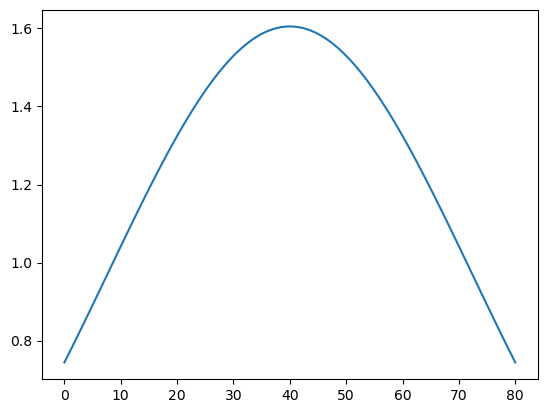

In [109]:
def gaussian_kernel(sigma, size):
    function = lambda x,y: np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2) / (2*(sigma**2)))
    kernel = np.fromfunction(function, (size, size), dtype=float)
    return kernel# / np.sum(kernel)

fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = gaussian_kernel(sigma, 80)
gaussian_window /= gaussian_window.mean()
# plt.imshow(gaussian_window, cmap='gray')
# plt.colorbar()
plt.plot(np.linspace(0,80,80), gaussian_window[40,:])

In [110]:
ncs = [32, 16, 8]
rec_fulls = []
# pretrained_epochs = [58, 61, 130] # MultiScale
pretrained_epochs = [118, 156, 170]
loss = 'MultiScale' # 'MSE'
for nc, pretrained_epoch in zip(ncs, pretrained_epochs):
    model = WienerNet(nc=[nc, nc*2, nc*4, nc*8])
    model.to(device)
    pretrained_file = os.path.join('../saved_models_Brain/', f'WienerNet_{nc}channels_{loss}_{pretrained_epoch}epochs.pth')
    model.load_state_dict(torch.load(pretrained_file, map_location=torch.device(device)))
    print(f'Successfully loaded in {pretrained_file}.')
    model.eval()
    
    rec_full, weights = np.zeros_like(IP_img), np.zeros_like(IP_img)
    for i in range(13):
        for j in range(13):
            obs, psf = torch.Tensor(obss[i*13+j]), psfs[i*13+j]
            obs, psf = obs.unsqueeze(0).to(device), psf.to(device)
            mean = obs.abs().mean()
            with torch.no_grad():
                rec = model(obs/mean, psf) * mean
            rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
            rec_full[40*i:40*i+80, 40*j:40*j+80] += rec * gaussian_window
            # weights[20*i:20*i+80, 20*j:20*j+80] += 1
    # rec_full = rec_full/weights
    rec_fulls.append(rec_full/np.abs(rec_full).mean())

Successfully loaded in ../saved_models_Brain/WienerNet_32channels_MultiScale_118epochs.pth.
Successfully loaded in ../saved_models_Brain/WienerNet_16channels_MultiScale_156epochs.pth.
Successfully loaded in ../saved_models_Brain/WienerNet_8channels_MultiScale_170epochs.pth.


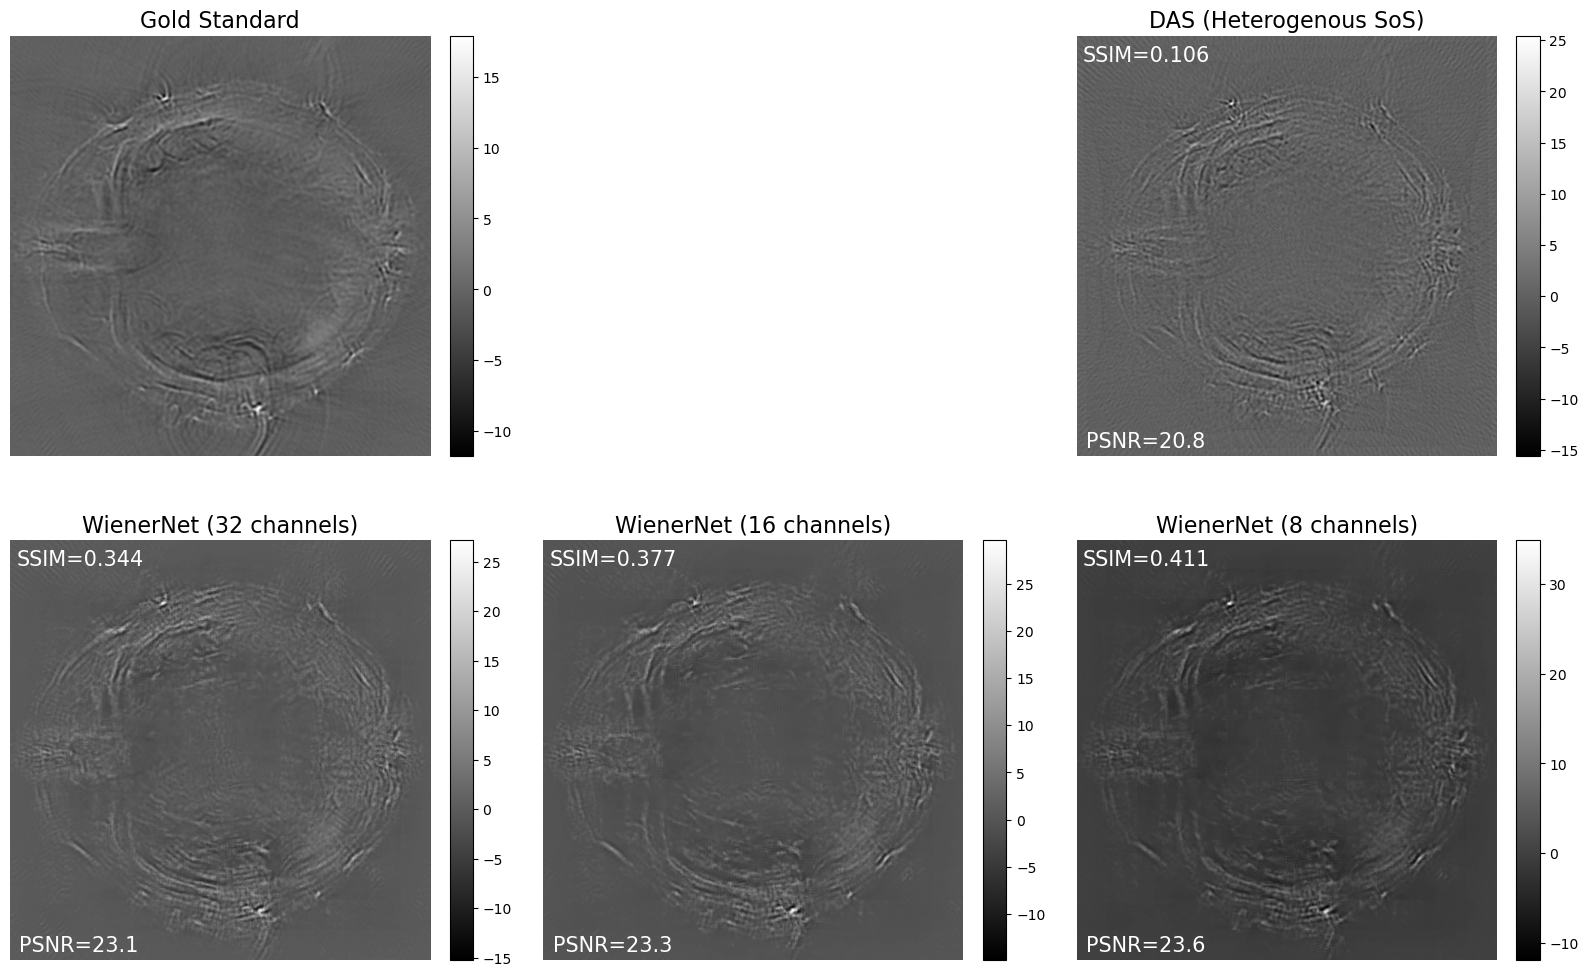

In [111]:
fig = plt.figure(figsize=(19.5, 12))
ax1 = plt.subplot(2,3,1)
plt.imshow(IP_img, cmap='gray')
plt.title('Gold Standard', fontsize=16)
plt.axis('off')
cax = fig.add_axes([ax1.get_position().x1+0.01, ax1.get_position().y0, 0.012, ax1.get_position().height])
cb = plt.colorbar(cax=cax)

# ax2 = plt.subplot(2,3,2)
# plt.imshow(gt_full, cmap='gray')
# plt.title('DAS (Homogenous SoS)', fontsize=16)
# plt.title("SSIM={:.3f}".format(ssim(gt_full, IP_img, data_range=20)), x=0.015, y=0.92, loc='left', fontsize=15, color='white')
# plt.title("PSNR={:.1f}".format(psnr(gt_full, IP_img, data_range=20)), x=0.306, y=0.0, loc='right', fontsize=15, color='white')
# plt.axis('off')
# cax = fig.add_axes([ax2.get_position().x1+0.01, ax2.get_position().y0, 0.012, ax2.get_position().height])
# cb = plt.colorbar(cax=cax)

ax3 = plt.subplot(2,3,3)
plt.imshow(obs_full[3], cmap='gray')
plt.title('DAS (Heterogenous SoS)', fontsize=16)
plt.title("SSIM={:.3f}".format(ssim(obs_full[3], IP_img, data_range=20)), x=0.015, y=0.92, loc='left', fontsize=15, color='white')
plt.title("PSNR={:.1f}".format(psnr(obs_full[3], IP_img, data_range=20)), x=0.306, y=0.0, loc='right', fontsize=15, color='white')
plt.axis('off')
cax = fig.add_axes([ax3.get_position().x1+0.01, ax3.get_position().y0, 0.012, ax3.get_position().height])
cb = plt.colorbar(cax=cax)

ax4 = plt.subplot(2,3,4)
plt.imshow(rec_fulls[0], cmap='gray')
plt.title(f'WienerNet ({ncs[0]} channels)', fontsize=16)
plt.title("SSIM={:.3f}".format(ssim(rec_fulls[0], IP_img, data_range=20)), x=0.015, y=0.92, loc='left', fontsize=15, color='white')
plt.title("PSNR={:.1f}".format(psnr(rec_fulls[0], IP_img, data_range=20)), x=0.306, y=0.0, loc='right', fontsize=15, color='white')
plt.axis('off')
cax = fig.add_axes([ax4.get_position().x1+0.01, ax4.get_position().y0, 0.012, ax4.get_position().height])
cb = plt.colorbar(cax=cax)

ax5 = plt.subplot(2,3,5)
plt.imshow(rec_fulls[1], cmap='gray')
plt.title(f'WienerNet ({ncs[1]} channels)', fontsize=16)
plt.title("SSIM={:.3f}".format(ssim(rec_fulls[1], IP_img, data_range=20)), x=0.015, y=0.92, loc='left', fontsize=15, color='white')
plt.title("PSNR={:.1f}".format(psnr(rec_fulls[1], IP_img, data_range=20)), x=0.306, y=0.0, loc='right', fontsize=15, color='white')
plt.axis('off')
cax = fig.add_axes([ax5.get_position().x1+0.01, ax5.get_position().y0, 0.012, ax5.get_position().height])
cb = plt.colorbar(cax=cax)

ax6 = plt.subplot(2,3,6)
plt.imshow(rec_fulls[2], cmap='gray')
plt.title(f'WienerNet ({ncs[2]} channels)', fontsize=16)
plt.title("SSIM={:.3f}".format(ssim(rec_fulls[2], IP_img, data_range=20)), x=0.015, y=0.92, loc='left', fontsize=15, color='white')
plt.title("PSNR={:.1f}".format(psnr(rec_fulls[2], IP_img, data_range=20)), x=0.306, y=0.0, loc='right', fontsize=15, color='white')
plt.axis('off')
cax = fig.add_axes([ax6.get_position().x1+0.01, ax6.get_position().y0, 0.012, ax6.get_position().height])
cb = plt.colorbar(cax=cax)